## Data loading

In [1]:
library(mctest)

In [2]:
data <- read.table("data2.csv", header=TRUE, sep=",", dec=',',colClasses=c("character", "character", rep("numeric", 8), quote='"', rep("character", 3)))
#data <- data[data$STATE!='windbreak',] # Select windbreak or not
#data <- data[is.null(data$wood),]
height_data <- read.table("heights.csv", header=TRUE, sep=",", dec=',', colClasses=c("character", "numeric", "numeric"))
XSIZE <- 100
YSIZE <- 100
RESULT_KERNEL <- MASS::kde2d(data[,c('X')], data[,c('Y')], n=200)
BASE_FORMULA <- grouping ~ diameter + absdensity + height

Warning message in read.table("data2.csv", header = TRUE, sep = ",", dec = ",", :
“not all columns named in 'colClasses' exist”

### All trees kernel density estimation

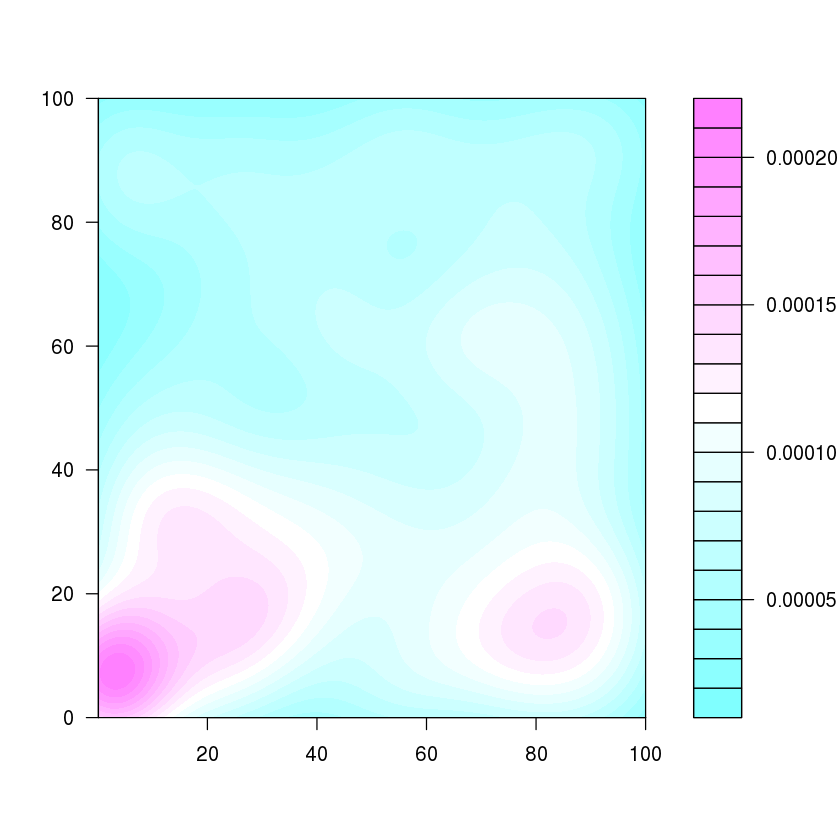

In [19]:
filled.contour(RESULT_KERNEL)

In [20]:
alive_data = data[data$STATE=='alive',]

### Alive trees kernel density estimation

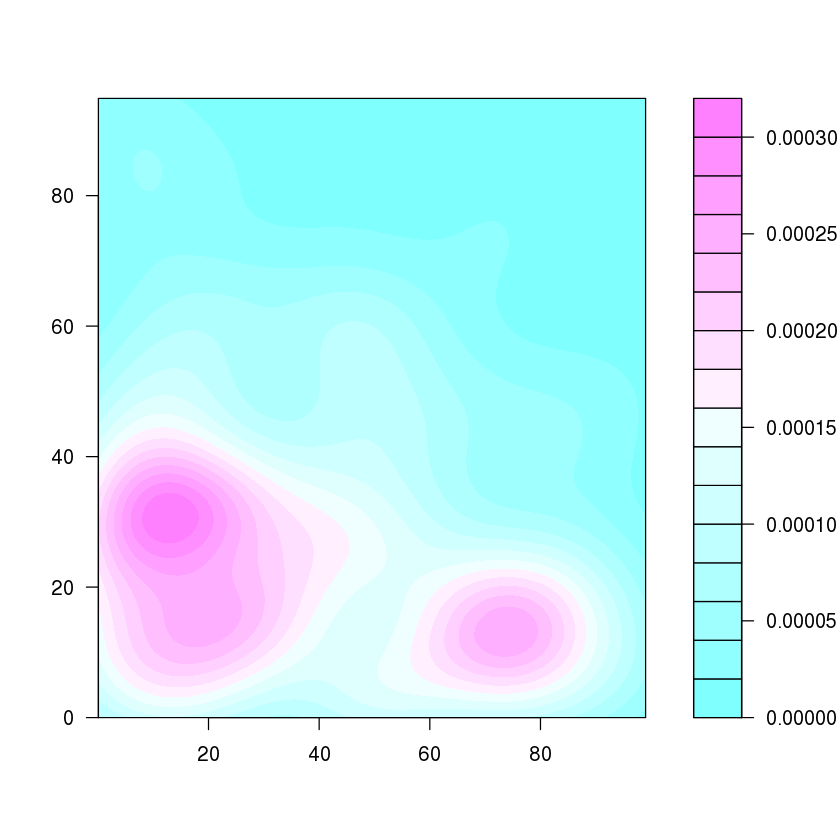

In [21]:
alive_kernel <- MASS::kde2d(alive_data[,c('X')], alive_data[,c('Y')], n=200)
filled.contour(alive_kernel)

## Utility function definitions

In [4]:
get.kernel.density <- function(x, y){
    return(RESULT_KERNEL$z[which.min(abs(RESULT_KERNEL$x-x)), which.min(abs(RESULT_KERNEL$y-y))])
}

get.absolute.density <- function(x, y, data, radius=5){
    within_circle_mask <- (data$X - x)^2 + (data$Y - y)^2 <= radius
    circle_area = pi * radius * radius
    return(sum(within_circle_mask)/circle_area)
}
get.relative.density <- function(x, y, data, status='alive', radius=5){ # Fatous trees!!!
    #' Get density at specified point (x, y)
    within_circle_mask <- (data$X - x)^2 + (data$Y - y)^2 <= radius^2
    filtered <- data[within_circle_mask, ]
    return(nrow(filtered[filtered$STATE == status,]) / nrow(filtered))
}

get.crown.size <- function(data, d, h){
    mask <- (!is.na(data[,'S']))
    if ((nrow(data[mask,])) > 3){
        newdf = data.frame(D=data[mask, 'D'],
                           H=data[mask, 'H'],
                           P=(data[mask,'N'] + data[mask, 'S'] + data[mask, 'E'] + data[mask, 'W']) / 4.0)
        model <- lm(P ~ D * H , data=newdf) # Use simple linear regression to get crown size estimation
        return(predict(model, newdata=data.frame(D=d, H=h)))
    }
    else{return(NA)}
}

get.height.by.diameter <- function(data, sp,  diam){
    mask <- (!is.na(data[,'H']))
    height_data<-NULL
    db_height <- rbind(data[mask, c('TYPE','D','H')], height_data)
    n <- nrow(db_height)
    if (n<3){
        h_predicted = median(db_height[,'H'])
    }
    else
        {
        # Use Curtis model: 
        # http://cs.uef.fi/sipu/pub/ModelingCurvesForPrediction.pdf 
        model <- nls(H  ~ 1.3 + a * D / (1 + D) ^ b, data=db_height, start=list(a=0.5,b=0.2))  # lets build non-linear regression model
        h_predicted = predict(model, newdata=data.frame(D=diam, H=0)) 
    }
    return(h_predicted)
}

build.data.frame <- function(tree_type, source, rel_status, radius, xmax, ymax){
 #' Builds data frame from source data using specified tree type
 
 if (tree_type == 'all'){
    auxiliary = source
 }
    else{
    auxiliary = source[source$TYPE==tree_type,]       
 }
 mask = rep(TRUE, nrow(auxiliary)) #!TODO: CHECK NEEDED!
 #mask = (auxiliary$X >= radius) & (auxiliary$Y >= radius) & (ymax - auxiliary$Y >= radius) & (xmax - auxiliary$X >= radius)
 auxiliary = auxiliary[mask,]
 density = rep(0, nrow(auxiliary))
 absdensity = rep(0, nrow(auxiliary))
 heights = rep(NA, nrow(auxiliary))
 crown_size = rep(NA, nrow(auxiliary))    
 for (i in 1: nrow(auxiliary)){
     intermediate <- auxiliary[i,]
     density[i] <- get.relative.density(intermediate$X, intermediate$Y, auxiliary, status=rel_status, radius=radius)
     
     if (is.na(auxiliary[i,'H']))
     { 
         heights[i]<-get.height.by.diameter(auxiliary, tree_type, auxiliary$D[i])
     }
     else {
         heights[i]<-auxiliary$H[i]
     }
     crown_size[i] <- get.crown.size(auxiliary, auxiliary$D[i], heights[i])
     #absdensity[i] <- get.absolute.density(intermediate$X, intermediate$Y, auxiliary, radius=radius)
     absdensity[i] <- get.kernel.density(intermediate$X, intermediate$Y)
 }
 result = data.frame(type=auxiliary$TYPE, density=density, absdensity=absdensity, diameter=auxiliary$D, height=heights,
                    crown_size=crown_size, wood=auxiliary$wood)
 grouping = as.character(auxiliary$STATE)
 grouping[grouping=='fautous'] = 0
 grouping[grouping!='alive'] = 1
 grouping[grouping=='alive'] = 0
 return(cbind(result, grouping))
}

loo <- function(data){
    result <- rep(0, nrow(data))
    for (i in 2:nrow(data)-1){
        train<-rbind(data[1:i-1,], data[(i+1):nrow(data),])
        test = data[i:i,]
        model <- glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
             data = train)
        pred<-as.integer(predict(model, newdata=test, type='response') > 0.5) 
        result[i]=as.integer(as.numeric(test$grouping)-1==pred)
    }
    
    return(sum(result)/length(result))
}

get.best.radius <- function(data, sp){ # THIS FUNCTION ISN"T TESTED YET
    radiuses <- seq(2, 8, by=0.5)
    aics <- rep(NA, length(radiuses))
    for (i in 1:length(radiuses)) {
        print("Evaluating:")
        print(i)
        train <- build.data.frame(sp, data, rel_status='alive', radius=radiuses[i], xmax=XSIZE, ymax=YSIZE)
        print(train)
        model <- glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
             data = train)
        aics[i]<-summary(model)$aic
    }
    return(radiuses(which.min(aics))) # return radius corresponding the smallest aic value
}

## Data analysis: getting started... 

In [5]:
species <-  c('all', 'Pinus koraiensis', 'broadleaf', 'Abies nephrolepis', 'Larix cajanderi')

In [6]:
for (sp in species){
   prepared_data <- build.data.frame(sp, data, rel_status='alive', radius=3, xmax=XSIZE, ymax=YSIZE)
   print(paste(sp, ':', "estimated LOOCV error: ", loo(prepared_data)))
   print(paste(sp, ':', 'percent of killed trees: ', sum(as.numeric(prepared_data$grouping)-1)/nrow(prepared_data)))
}

[1] "all : estimated LOOCV error:  0.710967741935484"
[1] "all : percent of killed trees:  0.664516129032258"
[1] "Pinus koraiensis : estimated LOOCV error:  0.853658536585366"
[1] "Pinus koraiensis : percent of killed trees:  0.703252032520325"
[1] "broadleaf : estimated LOOCV error:  0.777777777777778"
[1] "broadleaf : percent of killed trees:  0.716049382716049"
[1] "Abies nephrolepis : estimated LOOCV error:  0.664935064935065"
[1] "Abies nephrolepis : percent of killed trees:  0.638961038961039"
[1] "Larix cajanderi : estimated LOOCV error:  0.542857142857143"
[1] "Larix cajanderi : percent of killed trees:  0.714285714285714"


#### Conclusion 1

Unfortunately, accuracy estimations performed using leave-one-out cross validation (LOOCV) scheme are showing 
that all prediction strategies are quite weak.
For instance, if we look toward the `Pinus koraiensis` species and its accuracy estimation (0.85365), we will see that proportion of killed trees (0.7032520325) is not significantly less than the accuracy estimation. Therefore, if one would guess regarding the typhoon influence on Pinus koraiensis population, it is sufficient to suppose that all 
Pinus koraiensis trees  were killed. This proposition, in turn, will lead to a quite good prediction accuracy - 0.703 (approx.) Applying logistic regression in this case lead to increasing of the accuracy on (approx.) 0.16, i.e. new value of the accuracy becomes 0.0.85365.
In case of Larix species, the algorithm doesn't converge at all. In this case we have that simple proposion (all Larix specimens were killed) leads to better accuracy than applying logistic regression (unconverged).

## Logistic regression coefficients

### 1. Case: all species

In [7]:
prepared_data <- build.data.frame('all', data, rel_status='alive', radius=3, xmax=XSIZE, ymax=YSIZE)
model<-glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
             data = prepared_data)
summary(model)


Call:
glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
    data = prepared_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2692  -1.1756   0.6651   0.9083   1.5656  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.276e+00  2.967e-01   7.671 1.71e-14 ***
diameter     1.292e-01  1.741e-02   7.423 1.14e-13 ***
absdensity  -6.101e+03  1.806e+03  -3.378 0.000731 ***
height      -2.659e-01  3.802e-02  -6.994 2.67e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 988.89  on 774  degrees of freedom
Residual deviance: 899.04  on 771  degrees of freedom
AIC: 907.04

Number of Fisher Scoring iterations: 5


## Probability of tree falling (partial derivatives):

#### By height

In [8]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
-0.0640503

#### By diameter

In [9]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
0.02974552

#### By density

In [10]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
-0.03171344

#### Conclusion 2 (species=`All`) 

* Increasing in height (by 1 m) causes decreasing of probability of tree falling by -0.064 (approx.)
* Increasing in diameter (by 1 cm) causes increasing of probability of tree falling by 0.029 (approx.)
* increasing of local density of spatial distribution of trees by 10% causes decreasing of probability of tree falling by -0.03171 (approx.)


#### Multicollinearity test

In [11]:
omcdiag(prepared_data[,c('absdensity', 'diameter', 'height')], as.numeric(prepared_data[,'grouping']))


Call:
omcdiag(x = prepared_data[, c("absdensity", "diameter", "height")], 
    y = as.numeric(prepared_data[, "grouping"]))


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.1755         0
Farrar Chi-Square:      1340.6733         1
Red Indicator:             0.5310         1
Sum of Lambda Inverse:    12.2783         0
Theil's Method:            1.4761         1
Condition Number:         12.6755         0

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


### 2. Case: Pinus koraiensis

In [12]:
prepared_data <- build.data.frame('Pinus koraiensis', data, rel_status='alive', radius=3, xmax=XSIZE, ymax=YSIZE)
model<-glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
             data = prepared_data)
summary(model)


Call:
glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
    data = prepared_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0343  -0.5458   0.5559   0.7562   1.9283  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.290e+00  1.029e+00   6.110 9.96e-10 ***
diameter     1.704e-01  2.979e-02   5.718 1.08e-08 ***
absdensity  -5.990e+03  3.303e+03  -1.813   0.0698 .  
height      -5.080e-01  8.199e-02  -6.196 5.81e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 299.18  on 245  degrees of freedom
Residual deviance: 224.44  on 242  degrees of freedom
AIC: 232.44

Number of Fisher Scoring iterations: 6


#### Multicollinearity test

In [13]:
omcdiag(prepared_data[,c('absdensity', 'diameter', 'height')], as.numeric(prepared_data[,'grouping']))


Call:
omcdiag(x = prepared_data[, c("absdensity", "diameter", "height")], 
    y = as.numeric(prepared_data[, "grouping"]))


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.4560         0
Farrar Chi-Square:       189.5098         1
Red Indicator:             0.4257         0
Sum of Lambda Inverse:     5.3866         0
Theil's Method:            0.6629         1
Condition Number:         14.2105         0

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


## Probability of tree falling (partial derivatives):

#### By height

In [14]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
-0.09737441

#### By diameter

In [15]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
0.02720698

#### By density

In [16]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
-0.02261885

#### Conclusion 3 (species=`Pinus koraiensis`) 

* Increasing in height (by 1 m) causes decreasing of probability of tree falling by -0.097 (approx.)
* Increasing in diameter (by 1 cm) causes increasing of probability of tree falling by 0.027 (approx.)
* increasing of local density of spatial distribution of trees by 10% causes decreasing of probability of tree falling by -0.022 (approx.)


### 3. Case: Abies nephrolepis

In [17]:
prepared_data <- build.data.frame('Abies nephrolepis', data, rel_status='alive', radius=3, xmax=XSIZE, ymax=YSIZE)
model<-glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
             data = prepared_data)
summary(model)


Call:
glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
    data = prepared_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2109  -1.1429   0.5715   0.9645   1.6582  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.711e-01  4.865e-01   0.763 0.445608    
diameter     2.071e-01  4.654e-02   4.449 8.62e-06 ***
absdensity  -9.983e+03  2.788e+03  -3.581 0.000343 ***
height      -1.224e-01  7.638e-02  -1.603 0.108960    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 503.59  on 384  degrees of freedom
Residual deviance: 451.18  on 381  degrees of freedom
AIC: 459.18

Number of Fisher Scoring iterations: 5


#### Multicollinearity test

In [18]:
omcdiag(prepared_data[,c('absdensity', 'diameter', 'height')], as.numeric(prepared_data[,'grouping']))


Call:
omcdiag(x = prepared_data[, c("absdensity", "diameter", "height")], 
    y = as.numeric(prepared_data[, "grouping"]))


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.5183         0
Farrar Chi-Square:       249.9532         1
Red Indicator:             0.4039         0
Sum of Lambda Inverse:     4.8441         0
Theil's Method:            0.7730         1
Condition Number:         12.8167         0

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


## Probability of tree falling (partial derivatives):

#### By height

In [19]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
-0.02837596

#### By diameter

In [20]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
0.04560934

#### By density

In [21]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
-0.05092418

#### Conclusion 3 (species=`Abies nephrolepis`) 

* Increasing in height (by 1 m) causes decreasing of probability of tree falling by  -0.0283 (approx.)
* Increasing in diameter (by 1 cm) causes increasing of probability of tree falling by 0.0456 (approx.)
* increasing of local density of spatial distribution of trees by 10% causes decreasing of probability of tree falling by 0.05092 (approx.)


### 4. Case: broadleaf

In [22]:
prepared_data <- build.data.frame('broadleaf', data, rel_status='alive', radius=3, xmax=XSIZE, ymax=YSIZE)
model<-glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
             data = prepared_data)
summary(model)


Call:
glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
    data = prepared_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4370  -0.6522   0.5171   0.7041   1.6253  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.243e+00  1.028e+00   4.125 3.71e-05 ***
diameter     1.198e-01  4.121e-02   2.906  0.00366 ** 
absdensity  -1.676e+04  7.675e+03  -2.184  0.02899 *  
height      -3.573e-01  1.088e-01  -3.284  0.00102 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 96.657  on 80  degrees of freedom
Residual deviance: 76.210  on 77  degrees of freedom
AIC: 84.21

Number of Fisher Scoring iterations: 5


#### Multicollinearity test

In [23]:
omcdiag(prepared_data[,c('absdensity', 'diameter', 'height')], as.numeric(prepared_data[,'grouping']))


Call:
omcdiag(x = prepared_data[, c("absdensity", "diameter", "height")], 
    y = as.numeric(prepared_data[, "grouping"]))


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.2952         0
Farrar Chi-Square:        93.1239         1
Red Indicator:             0.5111         1
Sum of Lambda Inverse:     7.5067         0
Theil's Method:            0.9687         1
Condition Number:          9.7181         0

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


## Probability of tree falling (partial derivatives):

#### By height

In [24]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
-0.07254988

#### By diameter

In [25]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
0.02172362

#### By density

In [26]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
-0.07452416

#### Conclusion 3 (species=`broadleaf`) 

* Increasing in height (by 1 m) causes decreasing of probability of tree falling by  -0.0725(approx.)
* Increasing in diameter (by 1 cm) causes increasing of probability of tree falling by 0.0217 (approx.)
* increasing of local density of spatial distribution of trees by 10% causes decreasing of probability of tree falling by -0.074 (approx.)


### 4. Case: Larix cajanderi

In [27]:
prepared_data <- build.data.frame('Larix cajanderi', data, rel_status='alive', radius=3, xmax=XSIZE, ymax=YSIZE)
model<-glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
             data = prepared_data)
summary(model)


Call:
glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
    data = prepared_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6754  -1.0848   0.4771   0.7554   1.3610  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept)  5.582e-01  2.514e+00   0.222   0.8242  
diameter     5.762e-03  6.875e-02   0.084   0.9332  
absdensity   1.595e+04  7.935e+03   2.010   0.0445 *
height      -6.369e-02  1.695e-01  -0.376   0.7071  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 41.879  on 34  degrees of freedom
Residual deviance: 36.274  on 31  degrees of freedom
AIC: 44.274

Number of Fisher Scoring iterations: 4


#### Multicollinearity test

In [28]:
omcdiag(prepared_data[,c('absdensity', 'diameter', 'height')], as.numeric(prepared_data[,'grouping']))


Call:
omcdiag(x = prepared_data[, c("absdensity", "diameter", "height")], 
    y = as.numeric(prepared_data[, "grouping"]))


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.0894         0
Farrar Chi-Square:        73.2326         1
Red Indicator:             0.6562         1
Sum of Lambda Inverse:    19.0984         1
Theil's Method:            1.7085         1
Condition Number:         33.2938         1

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


## Probability of tree falling (partial derivatives):

#### By height

In [29]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
-0.0127684

#### By diameter

In [30]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
0.001137217

#### By density

In [31]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
0.06292914

#### Conclusion 3 (species=`Larix cajanderi`) 

* Increasing in height (by 1 m) causes decreasing of probability of tree falling by  -0.0127(approx.)
* Increasing in diameter (by 1 cm) causes increasing of probability of tree falling by 0.00113 (approx.)
* increasing of local density of spatial distribution of trees by 10% causes increasing of probability of tree falling by 0.06292 (approx.)


# The same analysis, but use presence of a `hollow` as an additional predictor

## Data analysis: getting started... 

In [32]:
data <- read.table("data2.csv", header=TRUE, sep=",", dec=',',colClasses=c("character", "character", rep("numeric", 8), quote='"', rep("character", 3)))
data <- rbind(data[data$wood=='centre',], data[data$wood=='hollow',])
BASE_FORMULA <- grouping ~ diameter + absdensity + height + wood

Warning message in read.table("data2.csv", header = TRUE, sep = ",", dec = ",", :
“not all columns named in 'colClasses' exist”

In [33]:
species <-  c('all', 'Pinus koraiensis', 'Larix cajanderi')

In [34]:
for (sp in species){
   prepared_data <- build.data.frame(sp, data, rel_status='alive', radius=3, xmax=XSIZE, ymax=YSIZE)
   print(paste(sp, ':', "estimated LOOCV error: ", loo(prepared_data)))
   print(paste(sp, ':', 'percent of killed trees: ', sum(as.numeric(prepared_data$grouping)-1)/nrow(prepared_data)))
}

[1] "all : estimated LOOCV error:  0.796052631578947"
[1] "all : percent of killed trees:  0.638157894736842"
[1] "Pinus koraiensis : estimated LOOCV error:  0.862595419847328"
[1] "Pinus koraiensis : percent of killed trees:  0.656488549618321"
[1] "Larix cajanderi : estimated LOOCV error:  0.3125"
[1] "Larix cajanderi : percent of killed trees:  0.5"


## Logistic regression coefficients

### 1. Case: all species

In [35]:
prepared_data <- build.data.frame('all', data, rel_status='alive', radius=3, xmax=XSIZE, ymax=YSIZE)
model<-glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
             data = prepared_data)
summary(model)


Call:
glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
    data = prepared_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5524  -0.7120   0.6232   0.8508   1.8420  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.279e+00  1.265e+00   4.173 3.01e-05 ***
diameter     1.977e-01  4.196e-02   4.713 2.44e-06 ***
absdensity  -6.482e+03  4.584e+03  -1.414    0.157    
height      -4.973e-01  1.040e-01  -4.782 1.73e-06 ***
woodhollow  -1.287e-01  4.458e-01  -0.289    0.773    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 198.96  on 151  degrees of freedom
Residual deviance: 153.52  on 147  degrees of freedom
AIC: 163.52

Number of Fisher Scoring iterations: 5


## Probability of tree falling (partial derivatives):

#### By wood

In [36]:
reshape2::dcast(prepared_data, grouping~wood)

Warning message in is.formula(formula):
“bytecode version mismatch; using eval”Using grouping as value column: use value.var to override.
Aggregation function missing: defaulting to length


grouping,centre,hollow
0,37,18
1,69,28


In [37]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity), wood='centre', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response')

1 
0.02759304

#### By height

In [39]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity),wood='hollow', height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response')
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity),wood='centre', height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='centre', height=median(prepared_data$height)), type='response')

1 
-0.1168833

1 
-0.1130007

#### By diameter

In [40]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),wood='hollow', absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,wood='centre', absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), wood='centre', absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
0.04181263

1 
0.03962128

#### By density

In [41]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response')
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), wood='centre', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity),  wood='centre', height=median(prepared_data$height)), type='response')

1 
-0.03167144

1 
-0.03028999

#### Multicollinearity test

In [42]:
omcdiag(prepared_data[,c('absdensity', 'diameter', 'height')], as.numeric(prepared_data[,'grouping']))


Call:
omcdiag(x = prepared_data[, c("absdensity", "diameter", "height")], 
    y = as.numeric(prepared_data[, "grouping"]))


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.4016         0
Farrar Chi-Square:       134.4146         1
Red Indicator:             0.4460         0
Sum of Lambda Inverse:     5.9843         0
Theil's Method:            0.8238         1
Condition Number:         15.0400         0

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


### 2. Case: Pinus koraiensis

In [43]:
prepared_data <- build.data.frame('Pinus koraiensis', data, rel_status='alive', radius=3, xmax=XSIZE, ymax=YSIZE)
model<-glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
             data = prepared_data)
summary(model)


Call:
glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
    data = prepared_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.6083  -0.5314   0.5551   0.7784   2.1341  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.826e+00  1.611e+00   4.238 2.25e-05 ***
diameter     2.210e-01  4.798e-02   4.607 4.09e-06 ***
absdensity  -5.816e+03  5.307e+03  -1.096    0.273    
height      -6.057e-01  1.270e-01  -4.768 1.86e-06 ***
woodhollow  -2.677e-01  5.112e-01  -0.524    0.601    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 168.55  on 130  degrees of freedom
Residual deviance: 119.15  on 126  degrees of freedom
AIC: 129.15

Number of Fisher Scoring iterations: 6


#### Multicollinearity test

In [44]:
omcdiag(prepared_data[,c('absdensity', 'diameter', 'height')], as.numeric(prepared_data[,'grouping']))


Call:
omcdiag(x = prepared_data[, c("absdensity", "diameter", "height")], 
    y = as.numeric(prepared_data[, "grouping"]))


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.4700         0
Farrar Chi-Square:        95.3871         1
Red Indicator:             0.4191         0
Sum of Lambda Inverse:     5.2621         0
Theil's Method:            0.6259         1
Condition Number:         14.3651         0

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


## Probability of tree falling (partial derivatives):

#### By wood

In [45]:
reshape2::dcast(prepared_data, grouping~wood)

Using grouping as value column: use value.var to override.
Aggregation function missing: defaulting to length


grouping,centre,hollow
0,30,15
1,60,26


In [46]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity), wood='centre', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response')

1 
0.05495325

#### By height

In [47]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity),wood='hollow', height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response')
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity),wood='centre', height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='centre', height=median(prepared_data$height)), type='response')

1 
-0.1426436

1 
-0.1322045

#### By diameter

In [48]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),wood='hollow', absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,wood='centre', absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), wood='centre', absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
0.04583211

1 
0.04046986

#### By density

In [49]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response')
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), wood='centre', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity),  wood='centre', height=median(prepared_data$height)), type='response')

1 
-0.02785355

1 
-0.02505787

### 4. Case: Larix cajanderi

In [50]:
prepared_data <- build.data.frame('Larix cajanderi', data, rel_status='alive', radius=3, xmax=XSIZE, ymax=YSIZE)
model<-glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
             data = prepared_data)
summary(model)


Call:
glm(formula = BASE_FORMULA, family = binomial(link = "logit"), 
    data = prepared_data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.63938  -1.10578   0.09286   1.04891   1.52074  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)
(Intercept) -8.007e+00  2.565e+01  -0.312    0.755
diameter    -3.711e-02  7.472e-02  -0.497    0.619
absdensity   5.338e+02  1.262e+04   0.042    0.966
height       3.298e-01  8.570e-01   0.385    0.700
woodhollow  -1.894e+00  1.519e+00  -1.247    0.212

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 22.181  on 15  degrees of freedom
Residual deviance: 20.359  on 11  degrees of freedom
AIC: 30.359

Number of Fisher Scoring iterations: 4


#### Multicollinearity test

In [51]:
omcdiag(prepared_data[,c('absdensity', 'diameter', 'height')], as.numeric(prepared_data[,'grouping']))


Call:
omcdiag(x = prepared_data[, c("absdensity", "diameter", "height")], 
    y = as.numeric(prepared_data[, "grouping"]))


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.5514         0
Farrar Chi-Square:         6.7464         0
Red Indicator:             0.3683         0
Sum of Lambda Inverse:     4.7026         0
Theil's Method:            1.0350         1
Condition Number:        125.5703         1

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


# Probability of tree falling (partial derivatives):

#### By wood

In [52]:
reshape2::dcast(prepared_data, grouping~wood)

Using grouping as value column: use value.var to override.
Aggregation function missing: defaulting to length


grouping,centre,hollow
0,5,3
1,7,1


In [53]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity), wood='centre', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response')

1 
0.4118814

#### By height

In [54]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity),wood='hollow', height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response')
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity),wood='centre', height=median(prepared_data$height)+1), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='centre', height=median(prepared_data$height)), type='response')

1 
0.05341757

1 
0.07681857

#### By diameter

In [55]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),wood='hollow', absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter)+1,wood='centre', absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), wood='centre', absdensity=median(prepared_data$absdensity), height=median(prepared_data$height)), type='response')

1 
-0.00536258

1 
-0.009008101

#### By density

In [56]:
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity), wood='hollow', height=median(prepared_data$height)), type='response')
predict(model, newdata=data.frame(diameter=median(prepared_data$diameter),absdensity=median(prepared_data$absdensity) + 0.1*max(prepared_data$absdensity), wood='centre', height=median(prepared_data$height)), type='response') - predict(model, newdata=data.frame(diameter=median(prepared_data$diameter), absdensity=median(prepared_data$absdensity),  wood='centre', height=median(prepared_data$height)), type='response')

1 
0.001704508

1 
0.002806525

## Chi2 test 

In [83]:
for (sp in c('all', 'Pinus koraiensis', 'Larix cajanderi')){
    if (sp == 'all') {prepared_data <- data}
    else{
    prepared_data <- data[data$TYPE==sp,]}
    prepared_data<-cbind(prepared_data, data.frame(windfall=prepared_data$STATE=='windfall'))
    print(reshape2::dcast(prepared_data, windfall~wood)[,2:3])
    print(chisq.test((reshape2::dcast(prepared_data, windfall~wood))[,2:3]))
}

Using windfall as value column: use value.var to override.
Aggregation function missing: defaulting to length


  centre hollow
1     54     26
2     52     20


Using windfall as value column: use value.var to override.
Aggregation function missing: defaulting to length



	Pearson's Chi-squared test with Yates' continuity correction

data:  (reshape2::dcast(prepared_data, windfall ~ wood))[, 2:3]
X-squared = 0.20791, df = 1, p-value = 0.6484



Using windfall as value column: use value.var to override.
Aggregation function missing: defaulting to length


  centre hollow
1     44     22
2     46     19


Using windfall as value column: use value.var to override.
Aggregation function missing: defaulting to length



	Pearson's Chi-squared test with Yates' continuity correction

data:  (reshape2::dcast(prepared_data, windfall ~ wood))[, 2:3]
X-squared = 0.10104, df = 1, p-value = 0.7506



Using windfall as value column: use value.var to override.
Aggregation function missing: defaulting to length


  centre hollow
1      6      3
2      6      1


Using windfall as value column: use value.var to override.
Aggregation function missing: defaulting to length
Warning message in chisq.test((reshape2::dcast(prepared_data, windfall ~ wood))[, :
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test with Yates' continuity correction

data:  (reshape2::dcast(prepared_data, windfall ~ wood))[, 2:3]
X-squared = 0.084656, df = 1, p-value = 0.7711



# Conclusion&inclusion

Probability assesments of a tree falling and how it depends on local environmental conditions were based on logistic regression (Cox, 1958; Walker, Duncan, 1967). Standard bionomial model (value of the family parameter was chosen as `binomial(link='logit')` in R's `glm` function) was used with two possible outcomes: 0 -- intended for survived trees and 1 -- for broken ones. 
Original dataset was represented by tree coordinates, their diameters and partially height estimates (direct height measurements were available for survived trees only), presence or absence a hollow in a tree stem. Starting from these data,  the following set of predictors were formed: 1) tree diameter at breast height (1.3 m)(D); 2) tree height (H); 3) local density (exactly, local probability density estimation) of trees composition (P); 4) existence of a hollow in a tree stem (W).
Tree diameters were available for all trees in the dataset. Missing height values were estimated using Curtis model describing relationships between tree's diameter and height (Can, 2015). The nonlinear Curtosis regression model was trained on a dataset obtained by combining original records with existed diameters and heights and auxiliary data collected from almost the same location as the original dataset were. To get local density estimation all trees prior typhoon disaster were accounted. 
We considered two approaches to get assesement of local density: 1) counting the number of trees in a specified circle around the point of interest (a.k.a. Ripley's K-function approach (Ripley, 1976;1977)); 2) 2D kernel density estimation based on the `kde2d` function from the R's `MASS` package (Venables W.N., Ripley B.D., 2002). Preliminary computations showed that both approaches yielded almost the same result. Therefore, we stood with the 2D kernel density approch, giving us estimation of theoretical probability of tree presence.
To get multicollinearity assesment the `omcdiag` function from the `mctest` package was used (Imdadullah, Aslan, 2016). It was found that determinant of the covarition matrix is significantly (at least, at significance level 0.05) differs from zero in all studied cases. Trained logistic regression models are given in the table below:
<table>
    <thead>
        <tr><th colspan="6">Table AA. Logistic regression coefficients </th>
        </tr>
    </thead>
    <tbody>
    <tr>
        <td>Name</td>
        <td>I</td>
        <td>D</td>
        <td>P</td>
        <td>H</td>
        <td>W</td>
    </tr>
    <tr>
        <td>All</td>
        <td>0.29\*\*\*</td>
        <td>0.12\*\*\*</td>
        <td>-610.0\*\*\*</td>
        <td>-0.26\*\*\*</td>
        <td>-</td>
    </tr>
        
    <tr>
        <td>*Pinus koraiensis*</td>
        <td>6.29\*\*\*</td>
        <td>0.17\*\*\*</td>
        <td>-599.0 \*</td>
        <td>-0.51\*\*\*</td>
        <td>-</td>
    </tr>        
   
    <tr>
        <td>*Abies Nephrolepis*</td>
        <td>0.37</td>
        <td>0.21\*\*\*</td>
        <td>-998.3\*\*\*</td>
        <td>-0.12</td>
        <td>-</td>
    </tr>   
    
   <tr>
        <td>Broadleaf</td>
        <td>4.24\*\*\*</td>
        <td>0.12\*\*\*</td>
        <td>-1676\*</td>
        <td>-0.36</td>
        <td>-</td>
    </tr>   
    
   <tr>
        <td>*Larix cajanderi*</td>
        <td>0.56</td>
        <td>0.006</td>
        <td>1595\*</td>
        <td>-0.064</td>
        <td>-</td>
    </tr>  
    
    <tr><td colspan="6">**Hollow presence case**</td></tr>

   <tr>
        <td>All</td>
        <td>5.28\*\*\*</td>
        <td>0.19\*\*\*</td>
        <td>-648</td>
        <td>-0.49\*\*\*</td>
        <td>-0.13</td>
    </tr>  
    
    
    <tr>
        <td>Pinus koraiensis</td>
        <td>6.82\*\*\*</td>
        <td>0.22\*\*\*</td>
        <td>-581</td>
        <td>-0.61\*\*\*</td>
        <td>-0.27</td>
    </tr>  
     <tr>
        <td>Larix cajanderi</td>
    
        <td>-8.0</td>
        <td>-0.037</td>
        <td>533</td>
        <td>0.33</td>
        <td>-1.90</td>
    </tr>  
   </tbody>
</table>      


Accuracy evaluation was performed using leave one out cross validation (LOOCV) scheme (Table xx).

<table>
    <thead>
        <tr><th colspan="3">Table BB. LOOCV estimates (models without hollow presence) </th>
        </tr>
    </thead>
    <tbody>
    <tr>
        <td>Species Name</td>
        <td>LOO CV</td>
        <td>Percent of killed trees</td>
    </tr>
        
    <tr>
        <td>All</td>
        <td>0.71</td>
        <td>0.66</td>
    </tr>
        
    <tr>
        <td>Pinus koraiensis</td>
        <td>0.85</td>
        <td>0.70</td>
    </tr>
    
    <tr>
        <td>Broadleaved species</td>
        <td>0.77</td>
        <td>0.71</td>
    </tr>
     
    <tr>
        <td>Abies nephrolepis</td>
        <td>0.66</td>
        <td>0.63</td>
    </tr>

<tr>
        <td>Larix cajanderi</td>
        <td>0.54</td>
        <td>0.71</td>
    </tr>
    
     <tr><td colspan="3">**Hollow presence case**</td></tr>
     
    <tr>
        <td>All</td>
        <td>0.80</td>
        <td>0.64</td>
    </tr>
    
    <tr>
        <td>Pinus koraiensis</td>
        <td>0.86</td>
        <td>0.66</td>
    </tr>
    
    <tr>
        <td>Larix cajanderi</td>
        <td>0.31</td>
        <td>0.50</td>
    </tr>
    </tbody>
</table>

LOOCV estimates could be compared with values in the last column of the Table BB. 
For instance, considering *Pinus koraiensis* we got `0.70` as a percentage of killed trees and `0.85` as an
accuracy estimation for the corresponding logistic regression model. Therefore, the gain of using logistic model in comparison to the trivial model, that consist in supposing that all *Pinus koraiensis* trees were killed, is about 0.15. 
Diving in deep, we can conclude that it is not too bad: the percentage of accuracy improvement in this case is quite high, 0.15/(1-0.7), that equals 0.5.
So, using logistic regression allows us to reduce misclassification rate on 50% in comparison with a trivial model based on assumtion that all *pinus koraiensis* trees were killed. In case of *Larix cajanderi* we have an opposite case: applying logistic regression doesn't improve the accuracy. Considering the number of records with *Larix cajanderi* it becomes clear that the latter issue is due to insufficient number of records. The latter, in turn, causes insignificance of estimations of all regression coefficient in the model.








    

#### References 

   * Walker S.H., Duncan D.B. Estimation of the probability of an event as a function of several independent variables // Biometrika. 1967. 54 (1/2): 167–178. doi:10.2307/2333860.
   * Cox D.R.The regression analysis of binary sequences (with discussion) // J Roy Stat Soc B. 1958. 20 (2): 215–242. 
   * Can J. Modeling height-diameter curves for prediction // For. Res. 2015. 45: 826–837. doi:10.1139/cjfr-2015-0054
   * Venables W.N., Ripley B.D. Modern Applied Statistics with S. New York. Springer. 2002. Ed. 4. ISBN 0-387-95457-0
   * Ripley B.D. The second-order  analysis of stationary point processes //Journal of Applied Probability. 1976. 13: 255–266.
   * Ripley B.D. Modelling spatial patterns //Journal of the Royal Statistical Society. 1977. Series B. 39: 172–192.
   * Imdadullah M., Aslam M. mctest: An R Package for Deteection of Collinearity among Regressors// The R Journal. 2016. 8(2): 499-509.
      